# Advance Lane Finding

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images are given as input. The pipeline shall output an annotated video with the lane detection. The video will identify:
* The positions of the lane lines 
* The location of the vehicle relative to the center of the lane
* The radius of curvature of the road

# Steps for the pipeline are the following
* Camera calibration
* Distortion correction
* Applying color and gradients thresholds
* Perspective transform (birds-eye view)
* Detect lane pixels (sliding window search) to find the lane boundary
* Determine the curvature of the lane and vehicle position with respect to center
* Draw lane with curvature and boundaries
* Display the lane boundaries and numerical estimation of lane curvature and vehicle position
* Run pipeline and save the final output video

In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# setup the inside corners as in project instructions 
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

In [3]:
#helper function for printing two images side by side for comparing them
def print_images(input_image, output_image, output_image_title, nx, ny, cmap=None, step="", save=False ):
    #split the image in two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(nx,ny))
    
    #print the first image
    ax1.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    #Set title for first image
    ax1.set_title('Original Image', fontsize=20)
    
    #print second image depending on the flags
    if cmap == 'gray':
        ax2.imshow(output_image, cmap='gray')
    elif cmap == 'color':
        ax2.imshow(output_image)
    else:
        ax2.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)) 
    #Set second image title    
    ax2.set_title(output_image_title, fontsize=20)
    
    #save first image to output_images folder to mark step
    if save == True:
        image_path = "./output_images/" + step + ".png"
        f.savefig(image_path, bbox_inches="tight")


## Step1: Camera calibration

In [4]:
def calibrate_camera(images, display=False):    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # 3d points in real world space
    objpoints = []
    # 2d points in image plane
    imgpoints = [] 
    
    # Step through the list and search for chessboard corners
    img = None
    gray = None
    index = 0
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if display == True:
            
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                 
                #print images side by side and save first image to mark the step execution
                if index == 0:
                
                    print_images(mpimg.imread(fname), img, 'Image With Corners', nx, ny, "CameraCalibrationStep", True )
                    index = index + 1 
                else:
                    print_images(mpimg.imread(fname), img, 'Image With Corners', nx, ny )
                
        
    ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)
    
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
    
    return ret, mtx, dist, rvecs, tvecs



Camera successfully calibrated.


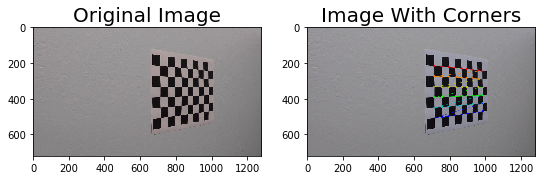

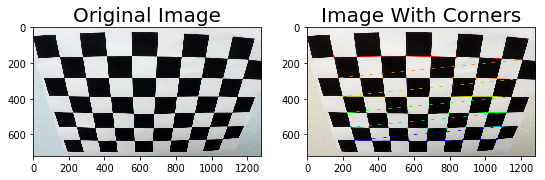

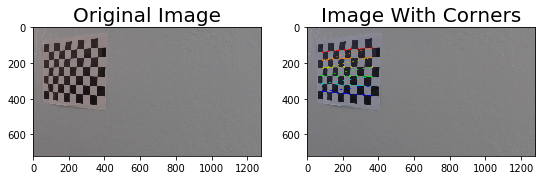

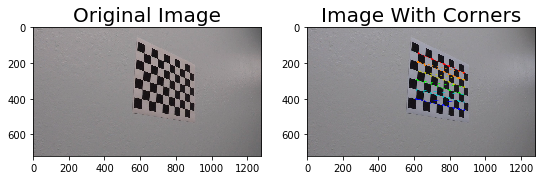

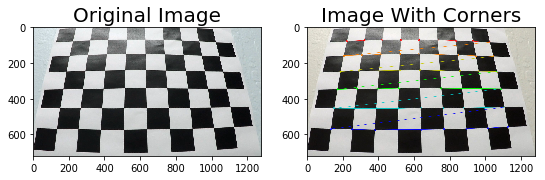

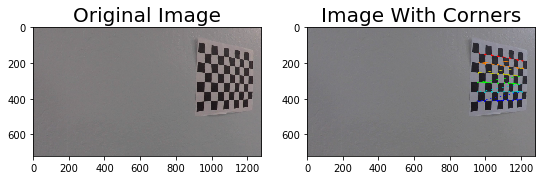

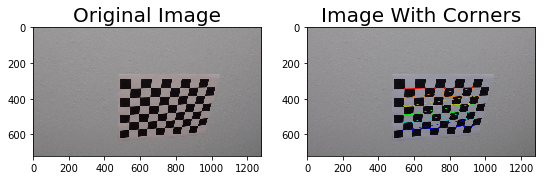

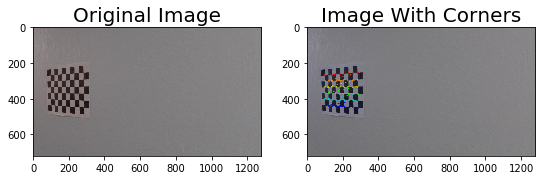

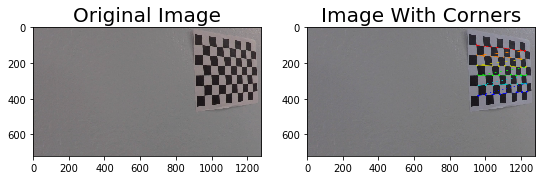

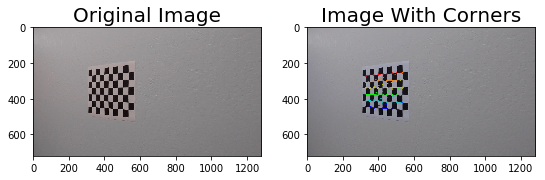

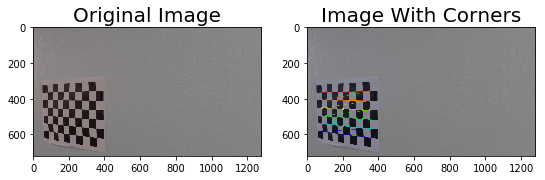

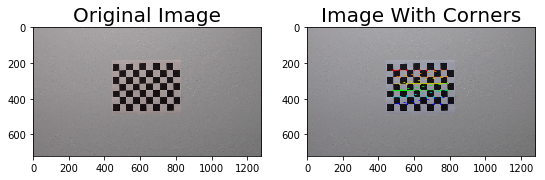

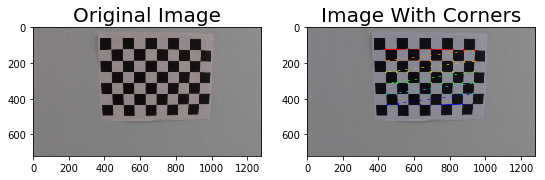

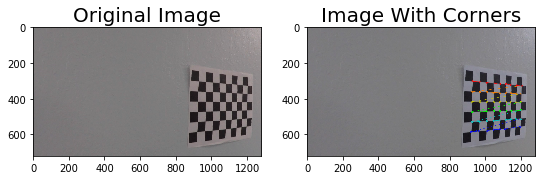

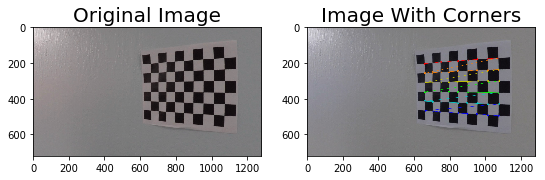

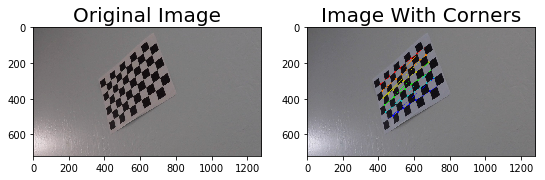

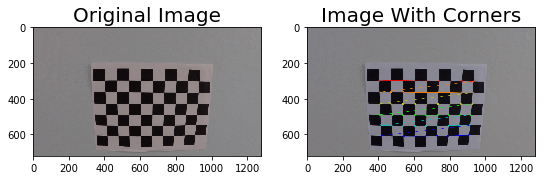

In [5]:
# read images from calibration folder matching the pattern
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, True)

## Step 2: Distortion correction

In [6]:
def undistort(image, display=False):
     
    #read current image    
    img = cv2.imread(image)
    #get size
    img_size = (img.shape[1], img.shape[0])
    #get undistorted image
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    if display == True:
        index = 0
        #print images side by side and save first image to mark the step execution
        if index == 0:
                
            print_images(img, undistorted_img, 'Undistorted Image', nx, ny, "DistortionCorrectionStep", True )
            index = index + 1 
        else:
            print_images(img, undistorted_img, 'Undistorted Image', nx, ny )
   
    return undistorted_img





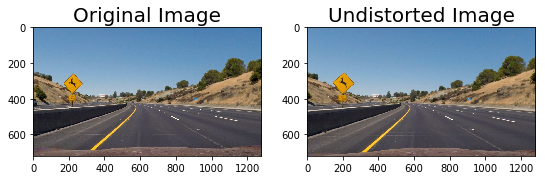

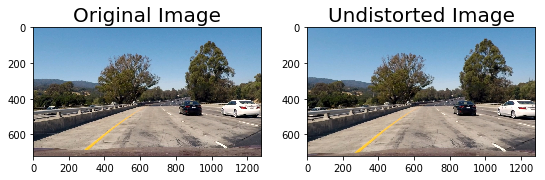

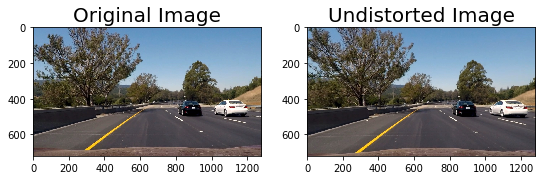

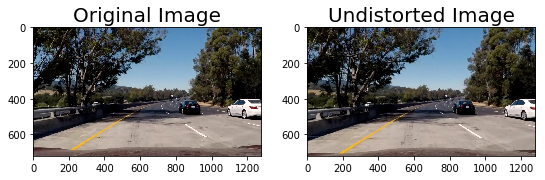

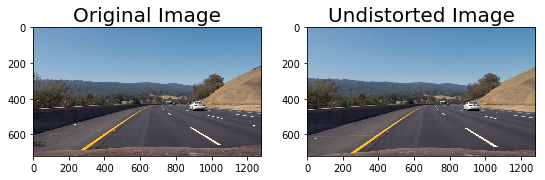

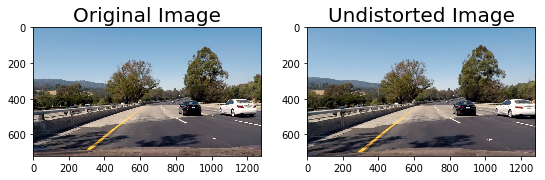

In [7]:
#read images from test_images folder and undistort them
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image, True)

## Step3: Applying color and gradients thresholds

### Get direction by applying sobel operator

In [8]:
# Load a test image, convert to RGB and undistort it
img = undistort('./test_images/test1.jpg')

In [9]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=10, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Return the result
    return binary_output

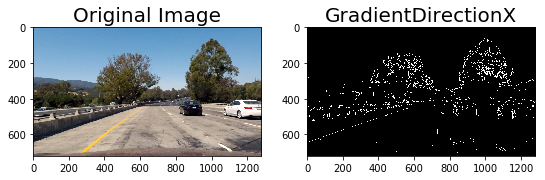

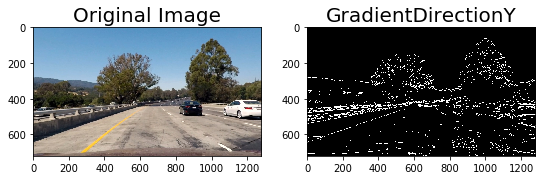

In [10]:
# Run the function
grad_x = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh_min=30, thresh_max = 100)
# Plot the results and save step image in output_images folder
print_images(img, grad_x, 'GradientDirectionX', nx, ny, cmap='gray', step='GradientDirectionXStep', save=True )
grad_y = abs_sobel_thresh(img, orient='y', sobel_kernel=15, thresh_min=30, thresh_max = 100)
# Plot the results and save step image in output_images folder
print_images(img, grad_y, 'GradientDirectionY', nx, ny, cmap='gray', step='GradientDirectionYStep', save=True )


### Get Gradient Magnitude

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thres(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output



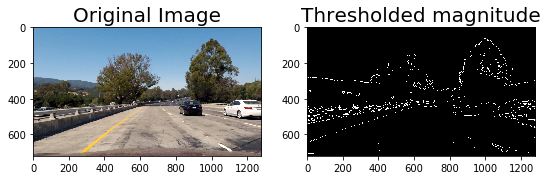

In [12]:
# Run the function
mag_binary = mag_thres(img, sobel_kernel=15, thresh_min=70, thresh_max=100)

# Plot the results and save step image in output_images folder
print_images(img, mag_binary, 'Thresholded magnitude', nx, ny, cmap='gray', step='ThresholdedMagnitudeStep', save=True )



### Get Direction Magnitude

In [13]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=9, thresh_min=0, thresh_max=np.pi/2):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1

    # Return the binary image
    return binary_output



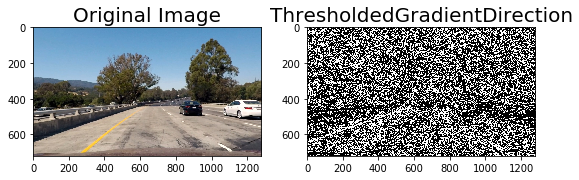

In [14]:
# Run the function
dir_binary = dir_thresh(img, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)

# Plot the results and save step image in output_images folder
print_images(img,dir_binary, 'ThresholdedGradientDirection', nx, ny, cmap='gray', step='ThresholdedGradientDirectionStep', save=True )



### Get Color Threshold

In [15]:
def col_thresh(img, thresh_min=170, thresh_max=255):
    # HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    s_channel = hls[:,:,2] 
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1

    # Return the binary image
    return binary_output

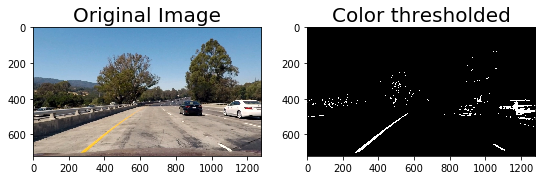

In [16]:
# Run the function
col_binary = col_thresh(img, thresh_min=170, thresh_max=255)

# Plot the results and save step image in output_images folder
print_images(img, col_binary, 'Color thresholded',nx, ny, cmap='gray', step='ThresholdedGradientColorStep', save=True )

### Combine all binary thresholds

In [17]:
#Function that combines all thresholds
def combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, kernel_size=15):
    # Combine the previous thresholds
    combined = np.zeros_like(dir_binary)
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1

    return combined



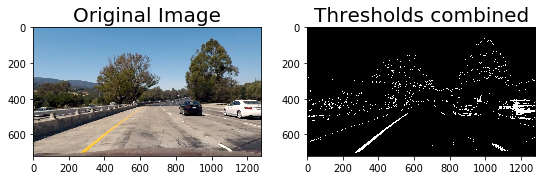

In [18]:
# Run the function
combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, kernel_size=15)

# Plot the results and save step image in output_images folder
print_images(img, combined, 'Thresholds combined', nx, ny, cmap='gray', step='ThresholdedCombinedStep', save=True ) 

## Step 4: Perspective transform

In [19]:
# Define perspective transform function
def warp(img, src_coordinates=None, dst_coordinates=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

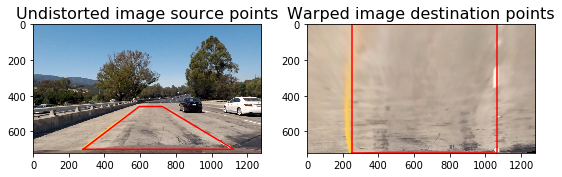

In [20]:
# Run the function
src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   

warped_img, _ , Minv  = warp(img, src_coordinates, dst_coordinates)

# Visualize undirstorsion
# Notice 'img' was undistorted at the beginning
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(nx,ny))
ax1.set_title('Undistorted image source points', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
#ax1.imshow(img)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('Warped image destination points', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
#ax2.imshow(warped_img)
ax2.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

#save the whole image
image_path = "./output_images/" + "PerspectiveTransformStep.png"
f.savefig(image_path, bbox_inches="tight")


## Step5: Detect line pixels

### Display Histogram Peaks

In [21]:
def get_histogram(img):
    return np.sum(img[img.shape[0]//2:, :], axis=0)


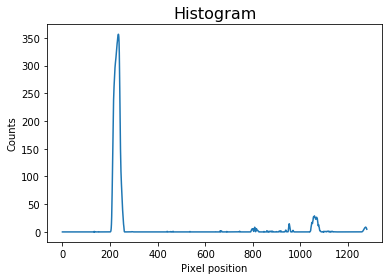

In [22]:
# Run de function over the combined warped image and the first item from tuple
combined_warped = warp(combined)[0]

#get histogram of combined warped image
histogram = get_histogram(combined_warped)

#plot the histogram
# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

### Prepare sliding windows

In [23]:
def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
        # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

     # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
  
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img


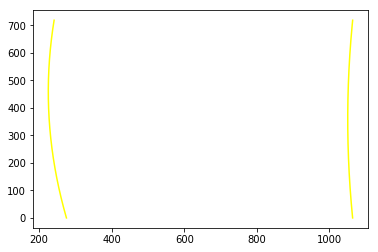

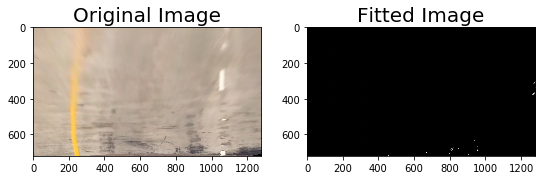

In [24]:
#get the image after applying second degree polynomial - last tupple parameter
fitted_img = find_lane_pixels(combined_warped)[3]
# Plot the results and save step image in output_images folder
print_images(warped_img, fitted_img, 'Fitted Image', nx, ny, 'color', step='FittedPolinomialStep', save=True ) 

### Search for similar lanes

In [25]:
def search_similar_lines(img, line_fits=None):
    if line_fits is None:
        return find_lane_pixels(img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return find_lane_pixels(img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
    for index in range(img.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img
    
  

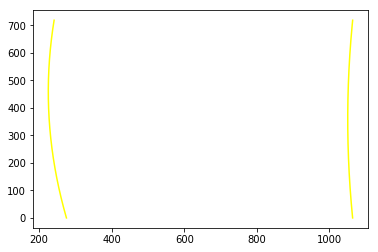

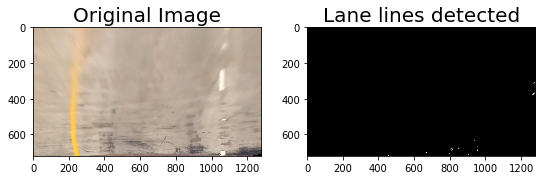

In [26]:
#get the line fits, left points, right points and final image
line_fits, left_points, right_points, out_img = search_similar_lines(combined_warped, None)
# Plot the results and save step image in output_images folder
print_images(warped_img, out_img, 'Lane lines detected', nx, ny, 'color', 'LaneMarkingStep', True)

## Step 6: Determine the curvature of the lane and vehicle position with respect to center

### Detect Curvature Radius

In [27]:
def get_curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [28]:
curvature_radius = get_curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)

# Print the results
print('Left line curvature:', curvature_radius[0], 'm')
print('Right line curvature:', curvature_radius[1], 'm')

Left line curvature: 550.272563248 m
Right line curvature: 1246.88995461 m


### Detect car offset towards the center

In [29]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [30]:
# Run the function
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
#print the car offset towards the center
print ('Car offset from center:', offsetx, 'm.')



Car offset from center: -0.0592634020088 m.


## Step 7: Draw lane with curvature and boundaries

### Draw lane 

In [31]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

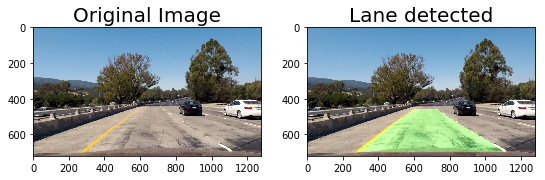

In [32]:
# Run the function
img_lane = draw_lane(img, combined_warped, left_points, right_points, Minv)
# Plot the results and save step image in output_images folder
print_images(img, img_lane, 'Lane detected', nx, ny , None, 'LaneDrawnStep', True)




## Step 8: Display the lane boundaries and numerical estimation of lane curvature and vehicle position

In [33]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = get_curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img



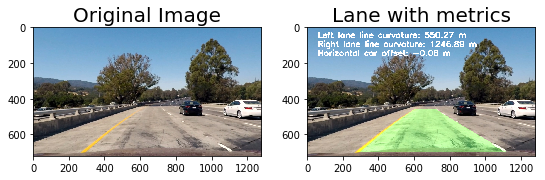

In [34]:
# Run the function
metrics_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])

# Plot the results and save step image in output_images folder
print_images(img, metrics_img, 'Lane with metrics', nx, ny, None, 'MetricsAddedStep', True)

## Step 9: Run pipeline and save the final output video

### Prepare pipeline class

In [35]:
class Pipeline:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines_fit = None

    def __call__(self, current_img):

        # Undistord image
        current_img = cv2.undistort(current_img, mtx, dist, None, mtx)

        # Calculate directional gradient
        grad_binary = abs_sobel_thresh(current_img, orient='x', sobel_kernel=15, thresh_min=30, thresh_max=100)

        # Calculate gradient magnitude 
        mag_binary = mag_thres(current_img, sobel_kernel=15, thresh_min=50, thresh_max=100)

        # Calculate gradient direction
        dir_binary = dir_thresh(current_img, sobel_kernel=15, thresh_min = 0.7, thresh_max = 1.3)

        # Calculate color threshold
        col_binary = col_thresh(current_img, thresh_min = 170, thresh_max = 255)

        # Combine all the thresholds to identify the lane lines
        combined = combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, kernel_size=15)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        combined_warped, _, Minv = warp(combined, src_coordinates, dst_coordinates)
                
        self.lines_fit, left_points, right_points, out_img = search_similar_lines(combined_warped, self.lines_fit)

        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw_lane(current_img, combined_warped, left_points, right_points, Minv)
            
        # Add metrics to the output image
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

### Prepare output video

Camera successfully calibrated.
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


100%|█████████▉| 1260/1261 [08:40<00:00,  2.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 5min 44s, sys: 44.6 s, total: 6min 28s
Wall time: 8min 42s


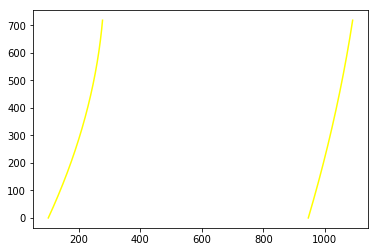

In [36]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

clip1 = VideoFileClip(input_video)

# Process video frames with Pipeline class 
process_image = Pipeline('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)



### Watch video

In [37]:

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))


### Check against challange video

Camera successfully calibrated.
[MoviePy] >>>> Building video ./challange_output.mp4
[MoviePy] Writing video ./challange_output.mp4


100%|██████████| 485/485 [03:12<00:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challange_output.mp4 

CPU times: user 2min 6s, sys: 17.2 s, total: 2min 24s
Wall time: 3min 15s


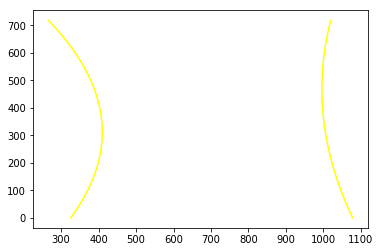

In [59]:
input_video = './challenge_video.mp4'
output_video = './challange_output.mp4'

clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = Pipeline('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)


In [60]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))